In [61]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [62]:
#"""此note book为期货回测框架的示例"""

In [63]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy as sp
from sklearn.covariance import ShrunkCovariance

In [64]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
from BackTestingEngine import futureBackTestingEngine as fte
#from config import *

In [65]:
%load_ext line_profiler
%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [66]:
def calShrunkCov(weekly_return):
    '''calculate Shrunk Covariance. ie. a 10 asset return array should return 10 * 10 dimension array
    Input: N * K np.array .
    Output: N * N array'''
    return ShrunkCovariance(0.1).fit(weekly_return.dropna().values).covariance_

def calEWMCovMatrix(facRetdf,decay=0.94):
    '''
    To calculate EWM covariance matrix of given facRetdf
    output: Dataframe, the ewm cov-matrix of the factors
    input:
    facRetdf: Dataframe, factor return dataframe
    decay: float, decay-factors
    Decay factors were set at:
    − 0.94 (1-day) from 112 days of data;
    − 0.97 (1-month) from 227 days of data.
    '''
    m,n = facRetdf.shape
    facDF = facRetdf - facRetdf.mean()
    for i in xrange(m):
        facDF.iloc[i] = np.sqrt(decay**(m-1-i)) * facDF.iloc[i]
    ewmCovMatrix = facDF.T.dot(facDF) * (1-decay)/(1-decay**m)
    return ewmCovMatrix

In [67]:
# 风险评价目标函数
def object_fun(x,return_cov):
    '''objective function for Risk budget portfolio
    Input: x ,n-d array ,the weight vector
           return_cov, the covariance of the asset return
    Output: ovjective function'''
    N = x.shape[0]   # get the number of asset
    covMatrix = np.matrix(return_cov)
    x = np.matrix(x)
    y = np.array(x) * (np.array(covMatrix * x.T).T)
    totalRisk = x * covMatrix * x.T
    b = totalRisk / N
    y = np.squeeze(np.asarray(y))  # return 1 dimension array in order to perform indexing
    totalY = y.sum()
    fval = 0
    for i in range(0,N):
        xi = (y[i]/totalY - b ) ** 2
        fval =fval +xi
    return fval

# 风险平价权重计算，输出为权重
def cal_RB_weight(cov):
    '''
    To calculate weight of portfolio with risk parity(the special case for risk budget portfolio)
    Input: Cov: n-d array, obtained from df.values
    Output: 1-d array, the weight vector
    '''

    bnds = ((0, 1),) * cov.shape[0]  # bounds for weights (number of bounds  = to number of assets)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
    x0 = np.ones(cov.shape[0]) * 1 / cov.shape[0]
    res = sp.optimize.minimize(object_fun, x0, args=cov, method='SLSQP', constraints=cons, bounds=bnds)
    if res.success:
        allocation = res.x
        allocation[allocation < 0] = 0  # since fund can not be shorted!
        denom = np.sum(allocation)
        if denom != 0:  # normalization process
            allocation = allocation / denom
    else:
        allocation = x0
    return allocation

In [68]:
path = 'C:/Users/kamis/Desktop/RB_Data/'

In [69]:
startTime =  datetime.strptime('20150501', '%Y%m%d')
endTime = datetime.strptime('20180119', '%Y%m%d')
initstartTime =  datetime.strptime('20150201', '%Y%m%d')
initendTime = datetime.strptime('20180119', '%Y%m%d')

In [70]:
##
filenameOpen = 'indexDataOpen.csv'
filenameClose = 'indexDataClose.csv'
filenameVolume = 'indexDataVolume.csv'

In [71]:
Open = pd.read_csv(path+filenameOpen,infer_datetime_format=True,parse_dates=[0],index_col=0).fillna(method="ffill")
Close = pd.read_csv(path+filenameClose,infer_datetime_format=True,parse_dates=[0],index_col=0).fillna(method="ffill")
Volume = pd.read_csv(path+filenameVolume,infer_datetime_format=True,parse_dates=[0],index_col=0).fillna(method="ffill")

In [72]:
# 初始化
test = fte.FutureBacktesting(path)

In [73]:
test.setInitCap(5000000)
test.availableCashNow

5000000

In [74]:
# 添加数据
test.addData('adjOpen',Open)
test.addData('adjClose',Close)
test.addData('volume',Volume)

In [75]:
# 截取回测区间和初始化区间
test.setBackTestingPeriod(startTime,endTime)
test.setInitialPeriod(initstartTime,initendTime)

In [76]:
# 各品种价格最小变动单位
tickSize = {'ALFI': 5.0,'HCFI': 1.0,'IFI': 0.5, 'JFI': 0.5,'JMFI': 0.5,'LFI': 5.0,'MAFI': 1.0,'MFI': 1.0,
 'PFI': 2.0, 'PPFI': 1.0, 'RBFI': 1.0, 'RMFI': 1.0, 'YFI': 2.0, 'ZCFI': 0.2}

In [77]:
# 各品种合约乘数
multiplier = {'ALFI': 5.0,'HCFI': 10.0,'IFI': 100.0,'JFI': 100.0,'JMFI': 60.0, 'LFI': 5.0,'MAFI': 10.0,'MFI': 10.0,
 'PFI': 10.0, 'PPFI': 5.0, 'RBFI': 10.0, 'RMFI': 10.0, 'YFI': 10.0, 'ZCFI': 100.0}

In [78]:
tradeSize = pd.Series(tickSize) * pd.Series(multiplier) * Open
tradeSize = (tradeSize.loc[test.backTestingDateList[0]].max() / tradeSize.loc[test.backTestingDateList[0]]).round(0)
tradeSize = tradeSize.to_dict()
tradeSize

{'ALFI': 1.0,
 'HCFI': 14.0,
 'IFI': 16.0,
 'JFI': 7.0,
 'JMFI': 17.0,
 'LFI': 1.0,
 'MAFI': 13.0,
 'MFI': 12.0,
 'PFI': 3.0,
 'PPFI': 7.0,
 'RBFI': 14.0,
 'RMFI': 15.0,
 'YFI': 3.0,
 'ZCFI': 40.0}

In [79]:
#(pd.Series(tickSize) * pd.Series(multiplier) * Open * pd.Series(tradeSize)).loc[test.backTestingDateList]

In [80]:
#tradeSize = np.floor(Open.loc[test.backTestingDateList[0]].loc['ALFI'] / Open.loc[test.backTestingDateList[0]])
#tradeSize = tradeSize.to_dict()

In [81]:
#tradeSize 

In [82]:
# 各品种保证金字典及合约乘数字典
#tickSize = {code: 1. for code in tradeSize.keys()}
marginRatio = {code: 0.15 for code in tradeSize.keys()}
#multiplier = {code: 10. for code in tradeSize.keys()}
test.setMarginRatio(marginRatio)
test.setTickSize(tickSize)
test.setMultiplier(multiplier)

In [83]:
test.tickSize

{'ALFI': 5.0,
 'HCFI': 1.0,
 'IFI': 0.5,
 'JFI': 0.5,
 'JMFI': 0.5,
 'LFI': 5.0,
 'MAFI': 1.0,
 'MFI': 1.0,
 'PFI': 2.0,
 'PPFI': 1.0,
 'RBFI': 1.0,
 'RMFI': 1.0,
 'YFI': 2.0,
 'ZCFI': 0.2}

In [84]:
test.multiplier

{'ALFI': 5.0,
 'HCFI': 10.0,
 'IFI': 100.0,
 'JFI': 100.0,
 'JMFI': 60.0,
 'LFI': 5.0,
 'MAFI': 10.0,
 'MFI': 10.0,
 'PFI': 10.0,
 'PPFI': 5.0,
 'RBFI': 10.0,
 'RMFI': 10.0,
 'YFI': 10.0,
 'ZCFI': 100.0}

In [85]:
# 双均线筛选买卖股
#动量因子筛选
X = 20
holdingNum = 4
Close = Close.dropna()
retXday = ((Close - Close.shift(X)) / Close.shift(X)).dropna(axis=0)

In [86]:
dailyRet = Close.pct_change()
dailyRet.tail()

,RBFI,ALFI,JFI,JMFI,ZCFI,HCFI,MFI,RMFI,YFI,MAFI,PPFI,PFI,LFI,IFI
2018-01-24,0.006698,-0.000453,0.003741,0.003453,0.011686,0.009211,-0.009038,-0.009238,0.003501,-0.009278,-0.004220,0.005450,-0.007573,0.001292
2018-01-25,0.007282,0.010053,0.031468,0.023155,0.005771,0.008373,0.008057,0.013095,-0.000335,0.009321,0.004836,-0.000669,0.005337,0.015201
2018-01-26,-0.005248,-0.010702,-0.011045,-0.013660,0.006260,-0.002880,-0.003586,-0.006601,0.003332,-0.004874,0.006123,0.001356,0.007075,-0.019991
2018-01-29,0.000104,0.003776,-0.003939,-0.010831,0.006972,0.000465,0.013153,0.017513,0.003261,0.006787,-0.003306,0.005476,-0.004721,-0.008398
2018-01-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [87]:
benchmarkData = test.dataDict['adjOpen'].loc[initstartTime:initendTime]
endOfWeekList = sorted(list(set(benchmarkData.iloc[benchmarkData.resample('W').size().cumsum().sub(1)].index)))
#tradeDate = sorted(list(set(retXday.iloc[retXday.resample('W').size().cumsum()].index)))
lsCombo = {}
weightList = []
for date in endOfWeekList:
    oneDayDict = {}
    sortedValue = retXday.loc[date].sort_values(ascending = False)
    longList = sortedValue.index[:holdingNum].tolist()
    shortList = sortedValue.index[-holdingNum:].tolist()
    oneDayDict['long'] = longList
    oneDayDict['short'] = shortList
    lsCombo[date] = oneDayDict
    # 利用risk budget计算权重多空权重
    #try:
     #   covariance = dailyRet[longList + shortList].loc[:date].iloc[-60:].dropna()
    #except:
     #   covariance = dailyRet[longList +shortList].loc[:date].dropna()
    #covariance = calEWMCovMatrix(covariance)
    #weightList.append(cal_RB_weight(covariance))
#weightdf=pd.DataFrame(index=endOfWeekList,data=weightList,columns = range(2*holdingNum))
#weightdf.iloc[:,-holdingNum:] = weightdf.iloc[:,-holdingNum:] * -1.

In [88]:
retXday['MakeOrderDay'] = retXday.index
orderDatePair = retXday.shift(-1)['MakeOrderDay'].loc[endOfWeekList]

In [89]:
orderDatePair.tail()

2017-12-22   2017-12-25
2017-12-29   2018-01-02
2018-01-05   2018-01-08
2018-01-12   2018-01-15
2018-01-19   2018-01-22
Name: MakeOrderDay, dtype: datetime64[ns]

In [90]:
# 按天循环
i = 0
for date in  test.backTestingDateList:
    #print date, 'Current position Num',len(test.getCurrentPosition())
    try:
        test.crossAllOrder(date)
    except KeyError:
        #print "No available order on %s"%date
        pass
    test.updateHoldingInfo(date)
    print i,date, test.getCurrentPosition().__len__()
    #i+=1
    #if i == 9:
     #   print 'longList',[key for  key,item in test.getCurrentPosition().iteritems() if item.direction ==1]
      #  print 'shortList',[key for  key,item in test.getCurrentPosition().iteritems() if item.direction == -1]
    if date in endOfWeekList[:-1]:
        #print date
        longList = lsCombo[date]['long']
        shortList = lsCombo[date]['short']
        orderDate = orderDatePair.loc[date]
        coverOrders = []
        # 区分有无持仓时，只有有持仓时才会先平仓再开仓   
        if test.getCurrentPosition():
            
            holdingLong = []
            holdingShort = []
            for code,item in test.getCurrentPosition().iteritems():
                if item.direction == 1:
                    holdingLong.append(code)
                else:
                    holdingShort.append(code)
            coverLongList = list(set(holdingLong) - set(longList) )
            coverShortList = list(set(holdingShort) - set(shortList) )
            longOpenList = list(set(longList) - set(holdingLong))
            shortOpenList =  list(set(shortList) - set(holdingShort))
            print orderDate,u"买开:",longOpenList
            print u"卖开:",shortOpenList
            print u"买平",coverLongList
            print u"卖平",coverShortList
            coverOrders = [test.makeOrder(orderDate ,stkID,test.getCurrentPosition()[stkID].volume,20,-test.getCurrentPosition()[stkID].direction,
                                         fte.Cover) \
                           for stkID in coverLongList + coverShortList]
            longOpenOrders =  [test.makeOrder(orderDate ,stkID,tradeSize[stkID],20,1,fte.Open) \
                           for stkID in longOpenList]
            shortOpenOrders = [test.makeOrder(orderDate ,stkID,tradeSize[stkID],20,-1,fte.Open) \
                           for stkID in shortOpenList]
            """
            #coverList = list(set(holdingLong) - longList) + list(set(holdingShort) - shortList)
            coverList = test.getCurrentPosition().keys()
            #print date, 'Current position Num',len(test.getCurrentPosition())
            #longList = list(set(longList) - set(test.getCurrentPosition().keys()))
            #shortList = list(set(shortList) - set(test.getCurrentPosition().keys()))
            #print date,"平仓：",coverList,'\n',"开多仓",longList,'\n',"开空仓",shortList,'\n'
            coverOrders = [test.makeOrder(orderDate ,stkID,test.getCurrentPosition()[stkID].volume,20,-test.getCurrentPosition()[stkID].direction,
                                         fte.Cover) \
                           for stkID in coverList]
            
            #totalOrders = sellOrders + buyOrders
        longOrders =  [test.makeOrder(orderDate ,stkID,tradeSize.loc[stkID],20,1,fte.Open) \
                           for stkID in longList]
        shortOrders = [test.makeOrder(orderDate ,stkID,tradeSize.loc[stkID],20,-1,fte.Open) \
                           for stkID in shortList]
            """
        else:
            coverOrders = []
            longOpenOrders  = [test.makeOrder(orderDate ,stkID,tradeSize[stkID],20,1,fte.Open) \
                       for stkID in longList]
            shortOpenOrders = [test.makeOrder(orderDate ,stkID,tradeSize[stkID],20,-1,fte.Open) \
                       for stkID in shortList]
        test.allOrdersDict[orderDate] = coverOrders + longOpenOrders  + shortOpenOrders  # 保存order到字典里

0 2015-05-04 00:00:00 0
0 2015-05-05 00:00:00 0
0 2015-05-06 00:00:00 0
0 2015-05-07 00:00:00 0
0 2015-05-08 00:00:00 0
0 2015-05-11 00:00:00 8
0 2015-05-14 00:00:00 8
0 2015-05-15 00:00:00 8
2015-05-18 00:00:00 买开: ['ZCFI']
卖开: ['JMFI', 'MAFI']
买平 ['HCFI']
卖平 ['LFI', 'ALFI']
0 2015-05-18 00:00:00 8
0 2015-05-19 00:00:00 8
0 2015-05-20 00:00:00 8
0 2015-05-21 00:00:00 8
0 2015-05-22 00:00:00 8
2015-05-25 00:00:00 买开: ['JMFI']
卖开: ['RMFI', 'LFI']
买平 ['YFI']
卖平 ['JMFI', 'MAFI']
0 2015-05-25 00:00:00 8
0 2015-05-26 00:00:00 8
0 2015-05-27 00:00:00 8
0 2015-05-28 00:00:00 8
0 2015-05-29 00:00:00 8
2015-06-01 00:00:00 买开: []
卖开: []
买平 []
卖平 []
0 2015-06-01 00:00:00 8
0 2015-06-02 00:00:00 8
0 2015-06-03 00:00:00 8
0 2015-06-04 00:00:00 8
0 2015-06-05 00:00:00 8
2015-06-08 00:00:00 买开: ['YFI']
卖开: ['ALFI']
买平 ['JMFI']
卖平 ['PPFI']
0 2015-06-08 00:00:00 8
0 2015-06-09 00:00:00 8
0 2015-06-10 00:00:00 8
0 2015-06-11 00:00:00 8
0 2015-06-12 00:00:00 8
2015-06-15 00:00:00 买开: ['JMFI', 'LFI', 'PPF

0 2016-03-29 00:00:00 8
0 2016-03-30 00:00:00 8
0 2016-03-31 00:00:00 8
0 2016-04-01 00:00:00 8
2016-04-05 00:00:00 买开: ['JFI']
卖开: ['RMFI', 'IFI']
买平 ['IFI']
卖平 ['JMFI', 'ALFI']
0 2016-04-05 00:00:00 8
0 2016-04-06 00:00:00 8
0 2016-04-07 00:00:00 8
0 2016-04-08 00:00:00 8
2016-04-11 00:00:00 买开: ['JMFI']
卖开: ['MAFI', 'PPFI']
买平 ['RBFI']
卖平 ['RMFI', 'MFI']
0 2016-04-11 00:00:00 8
0 2016-04-12 00:00:00 8
0 2016-04-13 00:00:00 8
0 2016-04-14 00:00:00 8
0 2016-04-15 00:00:00 8
2016-04-18 00:00:00 买开: ['RBFI']
卖开: []
买平 ['PFI']
卖平 []
0 2016-04-18 00:00:00 8
0 2016-04-19 00:00:00 8
0 2016-04-20 00:00:00 8
0 2016-04-21 00:00:00 8
0 2016-04-22 00:00:00 8
2016-04-25 00:00:00 买开: []
卖开: ['RMFI']
买平 []
卖平 ['IFI']
0 2016-04-25 00:00:00 8
0 2016-04-26 00:00:00 8
0 2016-04-27 00:00:00 8
0 2016-04-28 00:00:00 8
0 2016-04-29 00:00:00 8
2016-05-03 00:00:00 买开: ['IFI']
卖开: ['PFI', 'YFI']
买平 ['HCFI']
卖平 ['RMFI', 'MAFI']
0 2016-05-03 00:00:00 8
0 2016-05-04 00:00:00 8
0 2016-05-05 00:00:00 8
0 2016-05-0

0 2017-02-28 00:00:00 8
0 2017-03-01 00:00:00 8
0 2017-03-02 00:00:00 8
0 2017-03-03 00:00:00 8
2017-03-06 00:00:00 买开: ['JFI']
卖开: ['MAFI']
买平 ['ZCFI']
卖平 ['YFI']
0 2017-03-06 00:00:00 8
0 2017-03-07 00:00:00 8
0 2017-03-08 00:00:00 8
0 2017-03-09 00:00:00 8
0 2017-03-10 00:00:00 8
2017-03-13 00:00:00 买开: ['ZCFI']
卖开: []
买平 ['IFI']
卖平 []
0 2017-03-13 00:00:00 8
0 2017-03-14 00:00:00 8
0 2017-03-15 00:00:00 8
0 2017-03-16 00:00:00 8
0 2017-03-17 00:00:00 8
2017-03-20 00:00:00 买开: []
卖开: ['HCFI']
买平 []
卖平 ['PFI']
0 2017-03-20 00:00:00 8
0 2017-03-21 00:00:00 8
0 2017-03-22 00:00:00 8
0 2017-03-23 00:00:00 8
0 2017-03-24 00:00:00 8
2017-03-27 00:00:00 买开: ['ALFI']
卖开: ['RBFI', 'IFI']
买平 ['RBFI']
卖平 ['LFI', 'PPFI']
0 2017-03-27 00:00:00 8
0 2017-03-28 00:00:00 8
0 2017-03-29 00:00:00 8
0 2017-03-30 00:00:00 8
0 2017-03-31 00:00:00 8
2017-04-05 00:00:00 买开: []
卖开: ['YFI']
买平 []
卖平 ['RBFI']
0 2017-04-05 00:00:00 8
0 2017-04-06 00:00:00 8
0 2017-04-07 00:00:00 8
2017-04-10 00:00:00 买开: ['LFI

In [91]:
lsCombo

{Timestamp('2015-02-06 00:00:00'): {'long': ['PPFI', 'LFI', 'MAFI', 'ALFI'],
  'short': ['PFI', 'YFI', 'IFI', 'HCFI']},
 Timestamp('2015-02-13 00:00:00'): {'long': ['MAFI', 'PPFI', 'LFI', 'RMFI'],
  'short': ['YFI', 'ZCFI', 'HCFI', 'IFI']},
 Timestamp('2015-02-17 00:00:00'): {'long': ['PPFI', 'MAFI', 'LFI', 'RMFI'],
  'short': ['YFI', 'HCFI', 'IFI', 'ZCFI']},
 Timestamp('2015-02-27 00:00:00'): {'long': ['MAFI', 'PPFI', 'LFI', 'RMFI'],
  'short': ['JMFI', 'JFI', 'HCFI', 'ZCFI']},
 Timestamp('2015-03-06 00:00:00'): {'long': ['MAFI', 'LFI', 'PPFI', 'RMFI'],
  'short': ['JFI', 'HCFI', 'RBFI', 'IFI']},
 Timestamp('2015-03-13 00:00:00'): {'long': ['MAFI', 'RMFI', 'LFI', 'PPFI'],
  'short': ['RBFI', 'JFI', 'HCFI', 'IFI']},
 Timestamp('2015-03-20 00:00:00'): {'long': ['MAFI', 'RMFI', 'ALFI', 'PPFI'],
  'short': ['JMFI', 'PFI', 'JFI', 'IFI']},
 Timestamp('2015-03-27 00:00:00'): {'long': ['LFI', 'PPFI', 'ALFI', 'MAFI'],
  'short': ['ZCFI', 'PFI', 'JFI', 'IFI']},
 Timestamp('2015-04-03 00:00:00')

In [92]:
testdate = datetime.strptime('20150518', '%Y%m%d')
#lsCombo[test.backTestingDateList[8]]

In [93]:
def converToVolume(holdingclass):
    try:
        volume = holdingclass.volume * holdingclass.direction
        #volume =holdingclass.averageCost
    except:
        volume = np.NaN
    return volume

def converToAverageCost(holdingclass):
    try:
        #volume = holdingclass.volume * holdingclass.direction
        volume =holdingclass.averageCost
    except:
        volume = np.NaN
    return volume

In [94]:
pv = pd.DataFrame.from_dict(test.getAllPosition(), orient='index').applymap(converToVolume).sort_index(axis=1)
pa  = pd.DataFrame.from_dict(test.getAllPosition(), orient='index').applymap(converToAverageCost).sort_index(axis=1)

In [95]:
test.currentPositionDict

{'HCFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xe6ea518>,
 'IFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xf65aba8>,
 'JMFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xd9ec2e8>,
 'LFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xdbacbe0>,
 'MFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xfd70d30>,
 'PPFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xf62a780>,
 'RMFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xfc706a0>,
 'ZCFI': <BackTestingEngine.futureBackTestingEngine.holdingData at 0xea5a160>}

In [96]:
i1 = pa.loc[pa["IFI"].isnull()].iloc[0].name
pa.loc[:i1].iloc[:-1]

,ALFI,HCFI,IFI,JFI,JMFI,LFI,MAFI,MFI,PFI,PPFI,RBFI,RMFI,YFI,ZCFI
2015-05-11,-13458.661920,2494.355755,440.882483,NaN,NaN,-9761.441681,NaN,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,NaN
2015-05-14,-13458.661920,2494.355755,440.882483,NaN,NaN,-9761.441681,NaN,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,NaN
2015-05-15,-13458.661920,2494.355755,440.882483,NaN,NaN,-9761.441681,NaN,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,NaN
2015-05-18,NaN,NaN,440.882483,NaN,-671.834037,NaN,-2510.557241,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,423.585295
2015-05-19,NaN,NaN,440.882483,NaN,-671.834037,NaN,-2510.557241,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,423.585295
2015-05-20,NaN,NaN,440.882483,NaN,-671.834037,NaN,-2510.557241,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,423.585295
2015-05-21,NaN,NaN,440.882483,NaN,-671.834037,NaN,-2510.557241,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,423.585295
2015-05-22,NaN,NaN,440.882483,NaN,-671.834037,NaN,-2510.557241,-2733.197208,5034.236287,-8658.278949,NaN,NaN,5850.061744,423.585295
2015-05-25,NaN,NaN,440.882483,NaN,681.228264,-9529.927584,NaN,-2733.197208,5034.236287,-8658.278949,NaN,-2104.415787,NaN,423.585295
2015-05-26,NaN,NaN,440.882483,NaN,681.228264,-9529.927584,NaN,-2733.197208,5034.236287,-8658.278949,NaN,-2104.415787,NaN,423.585295


In [97]:
pv.loc["2017-8-1":]

,ALFI,HCFI,IFI,JFI,JMFI,LFI,MAFI,MFI,PFI,PPFI,RBFI,RMFI,YFI,ZCFI
2017-08-01,-1.0,14.0,16.0,7.0,17.0,NaN,-13.0,NaN,NaN,NaN,NaN,NaN,-3.0,-40.0
2017-08-02,-1.0,14.0,16.0,7.0,17.0,NaN,-13.0,NaN,NaN,NaN,NaN,NaN,-3.0,-40.0
2017-08-03,-1.0,14.0,16.0,7.0,17.0,NaN,-13.0,NaN,NaN,NaN,NaN,NaN,-3.0,-40.0
2017-08-04,-1.0,14.0,16.0,7.0,17.0,NaN,-13.0,NaN,NaN,NaN,NaN,NaN,-3.0,-40.0
2017-08-07,NaN,14.0,16.0,7.0,17.0,NaN,NaN,-12.0,-3.0,NaN,NaN,-15.0,NaN,-40.0
2017-08-08,NaN,14.0,16.0,7.0,17.0,NaN,NaN,-12.0,-3.0,NaN,NaN,-15.0,NaN,-40.0
2017-08-09,NaN,14.0,16.0,7.0,17.0,NaN,NaN,-12.0,-3.0,NaN,NaN,-15.0,NaN,-40.0
2017-08-10,NaN,14.0,16.0,7.0,17.0,NaN,NaN,-12.0,-3.0,NaN,NaN,-15.0,NaN,-40.0
2017-08-11,NaN,14.0,16.0,7.0,17.0,NaN,NaN,-12.0,-3.0,NaN,NaN,-15.0,NaN,-40.0
2017-08-14,1.0,NaN,16.0,7.0,17.0,NaN,NaN,-12.0,-3.0,NaN,NaN,-15.0,NaN,-40.0


In [98]:
test.backTestingDateList

DatetimeIndex(['2015-05-04', '2015-05-05', '2015-05-06', '2015-05-07',
               '2015-05-08', '2015-05-11', '2015-05-14', '2015-05-15',
               '2015-05-18', '2015-05-19',
               ...
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15', '2018-01-16', '2018-01-17',
               '2018-01-18', '2018-01-19'],
              dtype='datetime64[ns]', length=666, freq=None)

In [99]:
h = pd.DataFrame.from_dict(test.holdingPnlDict,orient='index').reindex(test.backTestingDateList).round(2)

In [100]:
#(p.sort_index(axis=1).index == h.sort_index(axis=1).index).any()

In [101]:
h.sort_index(axis=1).head(10).sum(axis=1)

2015-05-04        0.00
2015-05-05        0.00
2015-05-06        0.00
2015-05-07        0.00
2015-05-08        0.00
2015-05-11    17135.42
2015-05-14     8285.71
2015-05-15    16459.63
2015-05-18    15607.72
2015-05-19    13857.70
dtype: float64

In [102]:
intersection = list(set(test.backTestingDateList) & set(endOfWeekList))

In [103]:
closePrice = Close.loc[test.backTestingDateList[-1]]
holdingPnl ={}
for stkID, holding in test.getCurrentPosition().iteritems():
    print stkID, holding.direction,np.round(holding.averageCost,2),closePrice.loc[stkID]
    holdingPnl[stkID] = ( holding.direction*closePrice.loc[stkID] - holding.averageCost) * holding.volume

HCFI -1 -3838.12 3913.4144
MFI -1 -2776.14 2775.9027
LFI 1 10143.38 9846.6543
ZCFI -1 -639.06 653.3411
JMFI 1 1359.39 1286.7903
RMFI -1 -2295.79 2293.9899
IFI 1 509.65 545.2467
PPFI 1 9305.19 9461.4616


In [104]:
holdingPnl

{'HCFI': -1054.1500291700031,
 'IFI': 569.51584640000056,
 'JMFI': -1234.1602922500035,
 'LFI': -296.72744749999947,
 'MFI': 2.8808799600064958,
 'PPFI': 1093.9117249024985,
 'RMFI': 26.995943399997486,
 'ZCFI': -571.24278399999639}

In [105]:
closePrice 

RBFI     3906.0007
ALFI    14805.5125
JFI      1985.6574
JMFI     1286.7903
ZCFI      653.3411
HCFI     3913.4144
MFI      2775.9027
RMFI     2293.9899
YFI      5698.6618
MAFI     2791.4619
PPFI     9461.4616
PFI      5154.6578
LFI      9846.6543
IFI       545.2467
Name: 2018-01-19 00:00:00, dtype: float64

2018-02-13 14:33:34.409000	期末净值：	0.9879
2018-02-13 14:33:34.410000	总盈亏：	-60,740.1659
2018-02-13 14:33:34.410000	年化收益率：	-0.0046
2018-02-13 14:33:34.410000	年化波动率：	0.0702
2018-02-13 14:33:34.411000	夏普比率：	-0.0652
2018-02-13 14:33:34.411000	最大回撤: 	0.0602
2018-02-13 14:33:34.411000	换手率: 	0.1397
2018-02-13 14:33:34.411000	总手续费: 	22,768.0646


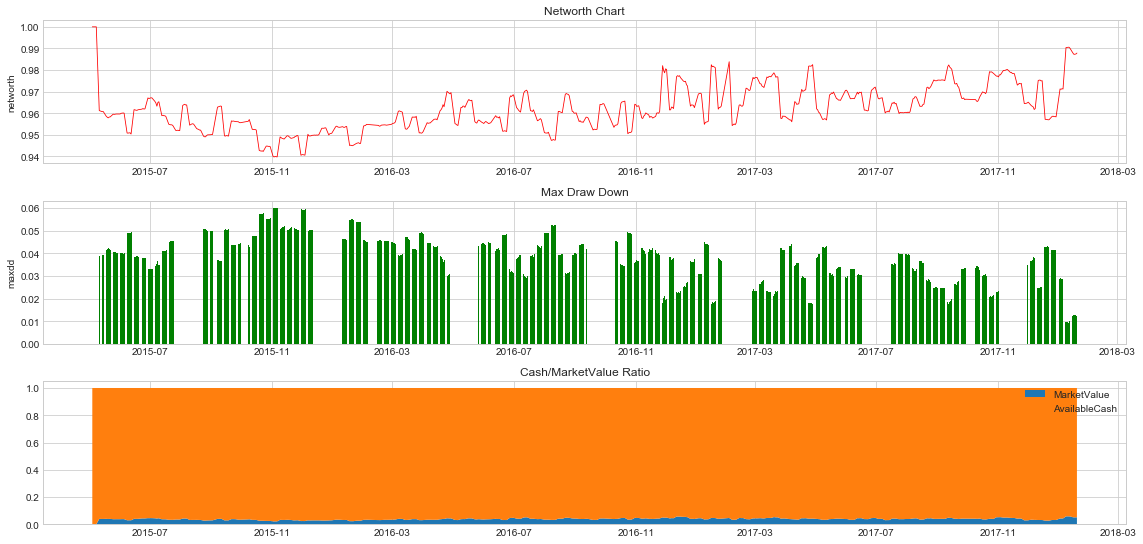

In [106]:
test.showBackTestingResult()

In [107]:
tradePnl = pd.DataFrame.from_dict(test.tradingPnlDict, orient='index')

In [108]:
tradePnl.loc['2015-06-15'].sort_values()

YFI    -701651.603317
ZCFI   -676294.299506
PFI    -608578.519884
LFI     476129.516142
PPFI              NaN
HCFI              NaN
ALFI              NaN
MAFI              NaN
RBFI              NaN
JMFI              NaN
JFI               NaN
IFI               NaN
RMFI              NaN
MFI               NaN
Name: 2015-06-15 00:00:00, dtype: float64

In [109]:
tradePnl

,YFI,PPFI,HCFI,ALFI,LFI,PFI,MAFI,RBFI,ZCFI,JMFI,JFI,IFI,RMFI,MFI
2015-05-18,NaN,NaN,-6.951000e+05,669029.612395,483729.484773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,-693016.451734,NaN,NaN,NaN,NaN,NaN,648109.756451,NaN,NaN,6.890951e+05,NaN,NaN,NaN,NaN
2015-06-08,NaN,596647.878249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.960976e+05,NaN,NaN,NaN,NaN
2015-06-15,-701651.603317,NaN,NaN,NaN,476129.516142,-608578.519884,NaN,NaN,-6.762943e+05,NaN,NaN,NaN,NaN,NaN
2015-06-23,NaN,NaN,NaN,NaN,-475933.155726,NaN,NaN,NaN,NaN,-6.985124e+05,NaN,NaN,631768.957547,640663.517678
2015-06-29,NaN,NaN,NaN,642812.298503,NaN,-613642.572872,NaN,NaN,NaN,NaN,NaN,-697929.693978,NaN,NaN
2015-07-06,NaN,NaN,NaN,NaN,NaN,NaN,-651138.807337,NaN,NaN,NaN,6.164618e+05,NaN,NaN,NaN
2015-07-13,NaN,-582782.872654,NaN,NaN,NaN,NaN,NaN,NaN,6.731063e+05,NaN,NaN,NaN,NaN,NaN
2015-07-20,NaN,NaN,NaN,NaN,NaN,NaN,-612219.771881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-27,NaN,NaN,NaN,NaN,-467750.422056,NaN,NaN,6.075424e+05,NaN,NaN,5.651200e+05,NaN,NaN,NaN


In [110]:
pa.loc['2015-06-15']

ALFI   -12980.968125
HCFI             NaN
IFI       440.882483
JFI              NaN
JMFI      690.752309
LFI      9517.479651
MAFI             NaN
MFI     -2733.197208
PFI              NaN
PPFI     8484.290936
RBFI    -2306.714111
RMFI    -2104.415787
YFI              NaN
ZCFI             NaN
Name: 2015-06-15 00:00:00, dtype: float64

In [111]:
pv

,ALFI,HCFI,IFI,JFI,JMFI,LFI,MAFI,MFI,PFI,PPFI,RBFI,RMFI,YFI,ZCFI
2015-05-11,-1.0,14.0,16.0,NaN,NaN,-1.0,NaN,-12.0,3.0,-7.0,NaN,NaN,3.0,NaN
2015-05-14,-1.0,14.0,16.0,NaN,NaN,-1.0,NaN,-12.0,3.0,-7.0,NaN,NaN,3.0,NaN
2015-05-15,-1.0,14.0,16.0,NaN,NaN,-1.0,NaN,-12.0,3.0,-7.0,NaN,NaN,3.0,NaN
2015-05-18,NaN,NaN,16.0,NaN,-17.0,NaN,-13.0,-12.0,3.0,-7.0,NaN,NaN,3.0,40.0
2015-05-19,NaN,NaN,16.0,NaN,-17.0,NaN,-13.0,-12.0,3.0,-7.0,NaN,NaN,3.0,40.0
2015-05-20,NaN,NaN,16.0,NaN,-17.0,NaN,-13.0,-12.0,3.0,-7.0,NaN,NaN,3.0,40.0
2015-05-21,NaN,NaN,16.0,NaN,-17.0,NaN,-13.0,-12.0,3.0,-7.0,NaN,NaN,3.0,40.0
2015-05-22,NaN,NaN,16.0,NaN,-17.0,NaN,-13.0,-12.0,3.0,-7.0,NaN,NaN,3.0,40.0
2015-05-25,NaN,NaN,16.0,NaN,17.0,-1.0,NaN,-12.0,3.0,-7.0,NaN,-15.0,NaN,40.0
2015-05-26,NaN,NaN,16.0,NaN,17.0,-1.0,NaN,-12.0,3.0,-7.0,NaN,-15.0,NaN,40.0


In [112]:
tradePnl.sort_index(axis=1)

,ALFI,HCFI,IFI,JFI,JMFI,LFI,MAFI,MFI,PFI,PPFI,RBFI,RMFI,YFI,ZCFI
2015-05-18,669029.612395,-6.951000e+05,NaN,NaN,NaN,483729.484773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,NaN,NaN,NaN,NaN,6.890951e+05,NaN,648109.756451,NaN,NaN,NaN,NaN,NaN,-693016.451734,NaN
2015-06-08,NaN,NaN,NaN,NaN,-6.960976e+05,NaN,NaN,NaN,NaN,596647.878249,NaN,NaN,NaN,NaN
2015-06-15,NaN,NaN,NaN,NaN,NaN,476129.516142,NaN,NaN,-608578.519884,NaN,NaN,NaN,-701651.603317,-6.762943e+05
2015-06-23,NaN,NaN,NaN,NaN,-6.985124e+05,-475933.155726,NaN,640663.517678,NaN,NaN,NaN,631768.957547,NaN,NaN
2015-06-29,642812.298503,NaN,-697929.693978,NaN,NaN,NaN,NaN,NaN,-613642.572872,NaN,NaN,NaN,NaN,NaN
2015-07-06,NaN,NaN,NaN,6.164618e+05,NaN,NaN,-651138.807337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-582782.872654,NaN,NaN,NaN,6.731063e+05
2015-07-20,NaN,NaN,NaN,NaN,NaN,NaN,-612219.771881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-27,NaN,NaN,NaN,5.651200e+05,NaN,-467750.422056,NaN,NaN,NaN,NaN,6.075424e+05,NaN,NaN,NaN


In [139]:
# 持仓pnl计算方式要修改！改为用持仓数据（volume）和持仓成本以及收盘价格算
totalPnl =pd.DataFrame.from_dict(test.holdingPnlDict, orient='index').round(2).sum(axis=1) \
+ pd.DataFrame.from_dict(test.tradingPnlDict, orient='index').reindex(test.backTestingDateList).round(2).sum(axis=1).cumsum().fillna(method='ffill')

In [140]:
totalPnl = totalPnl.fillna(0) + test.initCap
totalPnl

2015-05-04    5000000.00
2015-05-05    5000000.00
2015-05-06    5000000.00
2015-05-07    5000000.00
2015-05-08    5000000.00
2015-05-11    5017135.42
2015-05-14    5008285.71
2015-05-15    5016459.63
2015-05-18    5473266.78
2015-05-19    5471516.76
2015-05-20    5468194.40
2015-05-21    5466575.13
2015-05-22    5464038.03
2015-05-25    6133212.17
2015-05-26    6146713.42
2015-05-27    6145757.03
2015-05-28    6148726.48
2015-05-29    6152588.00
2015-06-01    6177880.31
2015-06-02    6168344.20
2015-06-03    6148396.07
2015-06-04    6152833.49
2015-06-05    6142898.46
2015-06-08    6031832.40
2015-06-09    6020737.63
2015-06-10    6032771.29
2015-06-11    6037062.61
2015-06-12    6033769.26
2015-06-15    4553834.22
2015-06-16    4540893.72
                 ...    
2017-12-08    9410953.69
2017-12-11    7020325.27
2017-12-12    7029250.30
2017-12-13    7026441.13
2017-12-14    7001821.75
2017-12-15    7025046.27
2017-12-18    5629565.00
2017-12-19    5621737.05
2017-12-20    5599739.46


In [141]:
totalPnl = totalPnl / totalPnl.iloc[0]

In [143]:
def simplePlot(df,title=""):
    #  Visualization
    fig = plt.figure(figsize=(16,9))
    # Add a subplot
    ax = fig.add_subplot(111)
    df.plot(ax = ax, fontsize =13,title = title)
    ax.set_title(ax.get_title(),alpha=1, fontsize=25)

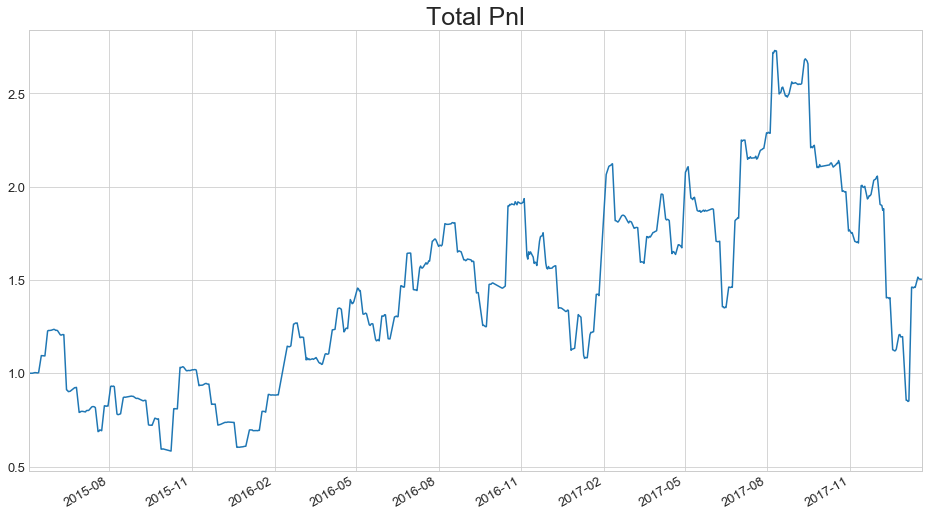

In [144]:
simplePlot(totalPnl,'Total Pnl')